In [1]:
import matplotlib as mpl
# mpl.use('Agg')
import sys
sys.path.append('/home/twilliams/adaptation_abm/code/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import code
# plt.rc('text', usetex=True)
import brewer2mpl
import os
import copy
import sys
from mpl_toolkits.axes_grid1 import ImageGrid
import xarray
import pickle
import logging
logger = logging.getLogger('sLogger')
from plot import plot_style
plot_type = 'paper'#'presentation_black_bg'
styles = plot_style.create() # get the plotting styles
styles['plot_type'] = plot_type
plt.style.use('fivethirtyeight')
plt.style.use(styles[plot_type])


In [2]:
exp_name = '2019_10_15_4'
all_ins_outname = '../../outputs/'+exp_name+'/policy_design/insurance/combined.csv'
all_cc_outname = '../../outputs/'+exp_name+'/policy_design/cover_crop/combined.csv'
d_cc = pickle.load(open(all_cc_outname, 'rb'))
d_ins = pickle.load(open(all_ins_outname, 'rb'))
shock_mags = [0.1]
shock_times = np.arange(2,31,step=2) # measured after the burn-in period
T_res = np.arange(1,16) # how many years to calculate effects over
outcomes = ['wealth','income']

Text(-0.2, 1.1, 'B: Insurance')

/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


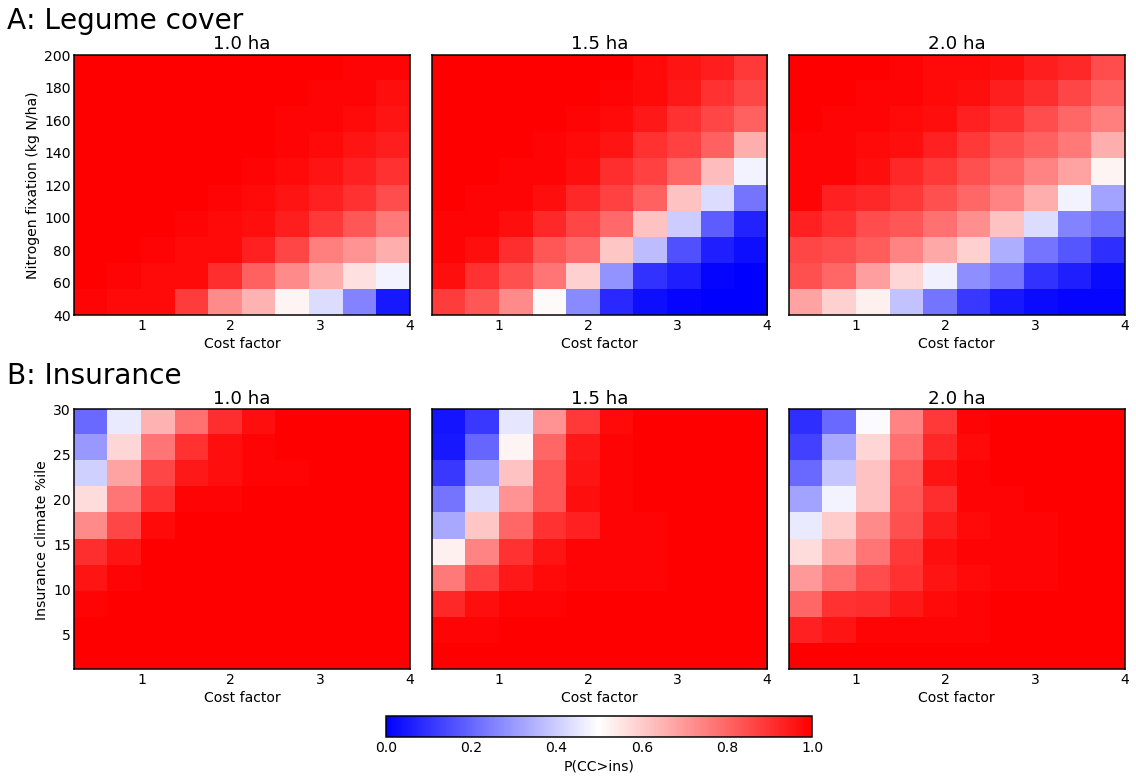

In [4]:
 savedir = '../outputs/{}/plots/'.format(exp_name)
mag_str = str(shock_mags[0]).replace('.','_')
outcome = list(d_cc.keys())[0]

# for outcome in d_cc.keys():
cc = d_cc[outcome]
ins = d_ins[outcome]
land_area = cc.columns

#### 1. simple figure ####
t_res = 5
t_shock = 10
fig, axs = plt.subplots(2,3,figsize=(16,10))
query_str = 'mag=="{}" & assess_pd=={} & time=={}'.format(mag_str, t_res, t_shock)
cc = cc.query(query_str)
ins = ins.query(query_str)
for li, land in enumerate(land_area):
    ## cover crop
    ax = axs[0,li]
    # code.interact(local=dict(globals(), **locals()))
    plt_data = np.array(cc[land].unstack())
    xs = cc.index.levels[4]
    ys = cc.index.levels[3]
    hm = ax.imshow(plt_data, cmap='bwr', vmin=0, vmax=1, origin='lower', extent=[min(xs), max(xs), min(ys), max(ys)],
                aspect='auto')

    ## insurance
    ax2 = axs[1,li]
    plt_data2 = np.array(ins[land].unstack())
    x2s = ins.index.levels[4]
    y2s = ins.index.levels[3] * 100 # convert to %age
    hm2 = ax2.imshow(plt_data2, cmap='bwr', vmin=0, vmax=1, origin='lower', extent=[min(x2s), max(x2s), min(y2s), max(y2s)],
                aspect='auto')
    
    # formatting
    if li > 0:
        for axx in [ax, ax2]:
            axx.set_ylabel('')
            axx.set_yticklabels([])
    else:
        ax.set_ylabel('Nitrogen fixation (kg N/ha)')
        ax2.set_ylabel('Insurance climate %ile')
    for axx in [ax, ax2]:
        axx.set_xlabel('Cost factor')
    for axx in [ax, ax2]:
        axx.set_title('{} ha'.format(land))
        axx.grid(False)

# color bar
cb_ax = fig.add_axes([0.34, -0.03, 0.37, 0.03])
cbar = fig.colorbar(hm2, orientation='horizontal', cax=cb_ax)
cbar.set_label('P(CC>ins)')

# labels
axs[0,0].text(-0.2, 1.1, 'A: Legume cover', fontsize=28, transform=axs[0,0].transAxes)
axs[1,0].text(-0.2, 1.1, 'B: Insurance', fontsize=28, transform=axs[1,0].transAxes)


In [17]:
p=0
d = d_ins
outcome = list(d_cc.keys())[0]
li = 0
land = land_area[0]
mag_str = str(shock_mags[0]).replace('.','_')
label = 'fraction insured'
defaults = [0.1,80]

T_res_plot = [1,2,5,10]
T_shock_plot = [2,6,10,16]

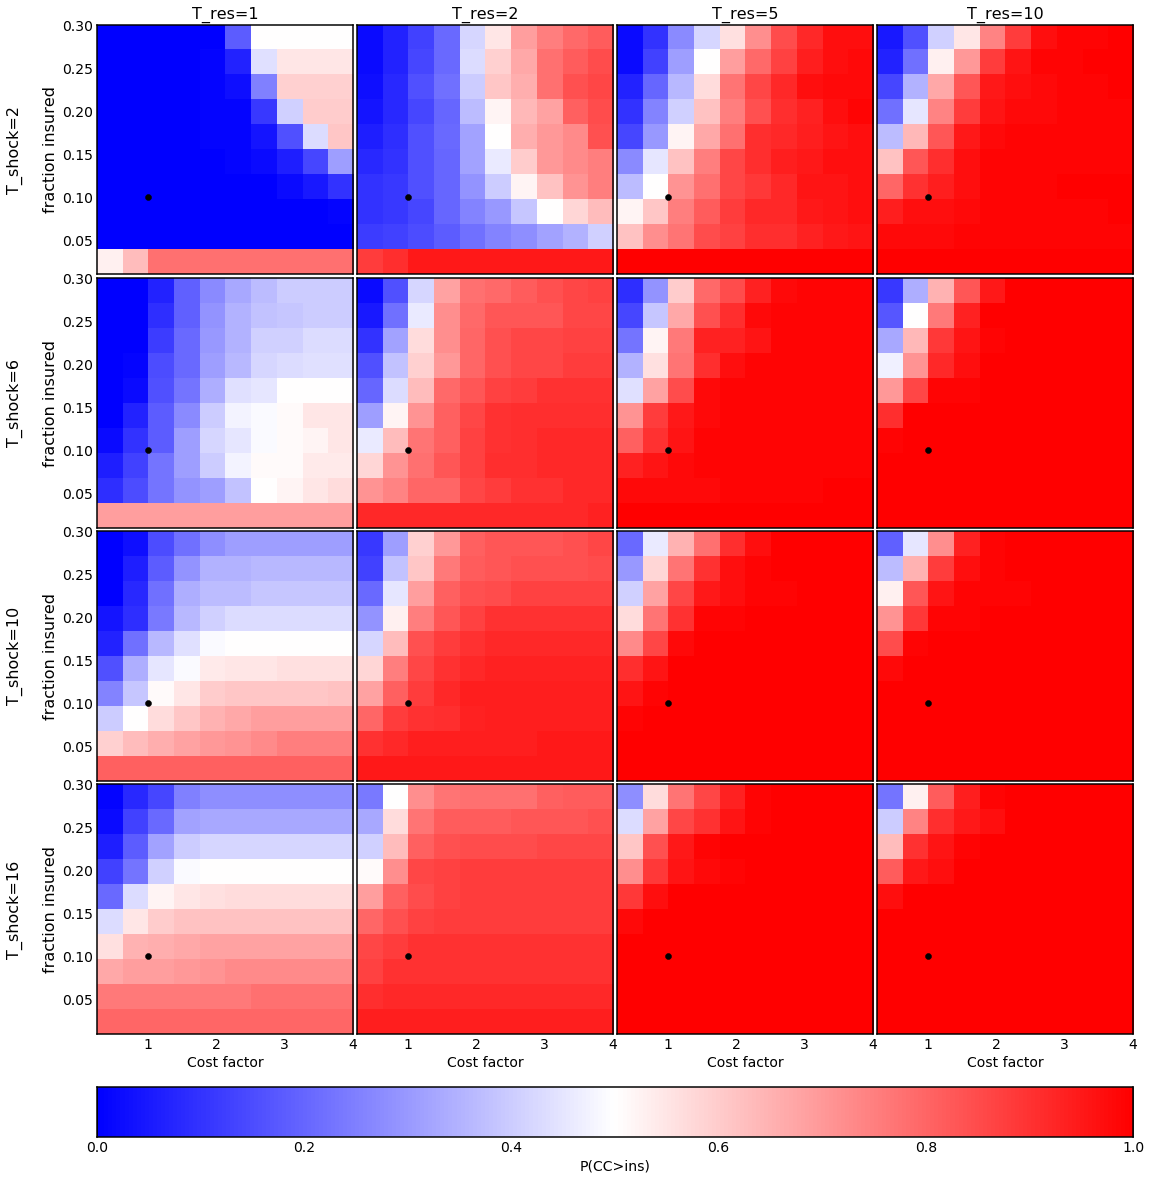

In [19]:
#### create figure ####
fig = plt.figure(figsize=(4*len(T_res_plot),4*len(T_shock_plot)))
axs = ImageGrid(fig, 111, nrows_ncols=(len(T_res_plot),len(T_shock_plot)), 
    axes_pad=0.05, add_all=True, label_mode='L',
    cbar_mode='single',cbar_location='bottom', aspect=False,
    cbar_pad='5%')

i=0
# loop over the plots
for ts, t_shock in enumerate(T_shock_plot):
    for tr, t_res in enumerate(T_res_plot):
        ax = axs[i]
        
        query_str = 'mag=="{}" & assess_pd=={} & time=={}'.format(mag_str, t_res, t_shock)
        d_subs = d[outcome].query(query_str)
        d_plot = np.array(d_subs[land].unstack())
        xs = d[outcome].index.levels[4]
        ys = d[outcome].index.levels[3]
        hm = ax.imshow(d_plot, cmap='bwr', vmin=0, vmax=1, origin='lower', extent=[min(xs), max(xs), min(ys), max(ys)],
                    aspect='auto')
        ax.scatter([1], [defaults[p]], color='k')
        i += 1
        
        # labels
        if ts == 0:
            ax.set_title('T_res={}'.format(t_res), fontsize=16)
        if tr == 0:
            ax.set_ylabel('T_shock={}\n\n{}'.format(t_shock, label), fontsize=16)
        if t_shock == max(T_shock_plot):
            ax.set_xlabel('Cost factor')
            
        # formatting
        ax.grid(False)

# colorbar
cax = axs.cbar_axes[0]
cbar = cax.colorbar(hm)
axis = cax.axis[cax.orientation]
axis.label.set_text("P(CC>ins)")

